# Embeddings

In this lesson we will learn how to map tokens to vectors (embeddings) that capture the contextual, semantic and syntactic value of a token in text.

<div align="left">
<a href="https://github.com/madewithml/lessons/blob/master/notebooks/02_Basics/08_Embeddings/08_PT_Embeddings.ipynb" role="button"><img class="notebook-badge-image" src="https://img.shields.io/static/v1?label=&amp;message=View%20On%20GitHub&amp;color=586069&amp;logo=github&amp;labelColor=2f363d"></a>&nbsp;
<a href="https://colab.research.google.com/github/madewithml/lessons/blob/master/notebooks/02_Basics/08_Embeddings/08_PT_Embeddings.ipynb"><img class="notebook-badge-image" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>
</div>

# Overview

So far, we've also represented our text data in a one-hot encoded form where each token is represented by an n-dimensional array.
 
 ```python
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
```

This allows us to preserve the structural information but there are two major disadvantages here. We used character level representations in the CNN lessons because the number of characters is small. Suppose we wanted to one-hot encode each word instead. Now the vocabulary sizes quickly grows leading to large computes. And though we preserve the structure within the text, the actual representation for each token does not preserve any relationship with respect to other tokens.

In this notebook, we're going to learn about embeddings and how they address all the shortcomings of the representation methods we've seen so far.





* **Objective:**  Represent tokens in text that capture the intrinsic semantic relationships.
* **Advantages:** 
    * Low-dimensionality while capturing relationships.
    * Interpretable token representations
* **Disadvantages:** None
* **Miscellaneous:** There are lot's of pretrained embeddings to choose from but you can also train your own from scratch.

# Data

## Load data

We can learn embeddings by creating our models in TensorFLow but instead, we're going to use a library that specializes in embeddings and topic modeling called [Gensim](https://radimrehurek.com/gensim/). 

In [0]:
import urllib

In [0]:
DATA_FILE = 'harrypotter.txt'

In [0]:
# Load data from GitHub to this notebook's local drive
url = "https://raw.githubusercontent.com/madewithml/lessons/master/data/harrypotter.txt"
response = urllib.request.urlopen(url)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)

## Preprocess

In [0]:
# Use TensorFlow 2.x
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import nltk; nltk.download('punkt')
import tensorflow as tf
from tensorflow.keras.preprocessing.text import text_to_word_sequence
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [0]:
SEED = 1234

In [0]:
# Set seed for reproducibility
tf.random.set_seed(SEED)

In [0]:
FILTERS = "!\"'#$%&()*+,-./:;<=>?@[\\]^_`{|}~"
LOWER = True

In [0]:
# Split text into sentences
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
with open(DATA_FILE, encoding='cp1252') as fp:
    book = fp.read()
sentences = tokenizer.tokenize(book)
print (f"{len(sentences)} sentences")

15640 sentences


In [0]:
# Preprocess sentences
print (sentences[11])
sentences = [text_to_word_sequence(
    text=sentence, filters=FILTERS, 
    lower=LOWER, split=' ') for sentence in sentences]
print (sentences[11])

Snape nodded, but did not elaborate.
['snape', 'nodded', 'but', 'did', 'not', 'elaborate']


# Learning embeddings

The main idea of embeddings is to have fixed length representations for the tokens in a text regardless of the number of tokens in the vocabulary. So instead of each token representation having the shape [1 X V] where V is vocab size, each token now has the shape [1 X D] where D is the embedding size (usually 50, 100, 200, 300). The numbers in the representation will no longer be 0s and 1s but rather floats that represent that token in a D-dimensional latent space. If the embeddings really did capture the relationship between tokens, then we should be able to inspect this latent space and confirm known relationships (we'll do this soon).

But how do we learn the embeddings the first place? The intuition behind embeddings is that the definition of a token depends on the token itself but on its context. There are several different ways of doing this:

1. Given the word in the context, predict the target word (CBOW - continuous bag of words).
2. Given the target word, predict the context word (skip-gram).
3. Given a sequence of words, predict the next word (LM - language modeling).

All of these approaches involve create data to train our model on. Every word in a sentence becomes the target word and the context words are determines by a window. In the image below (skip-gram), the window size is 2 (2 words to the left and right of the target word). We repeat this for every sentence in our corpus and this results in our training data for the unsupervised task. This in an unsupervised learning technique since we don't have official labels for contexts. The idea is that similar target words will appear with similar contexts and we can learn this relationship by repeatedly training our mode with (context, target) pairs.

<div align="left">
<img src="https://raw.githubusercontent.com/madewithml/images/master/02_Basics/08_Embeddings/skipgram.png" width="600">
</div>

We can learn embeddings using any of these approaches above and some work better than others. You can inspect the learned embeddings but the best way to choose an approach is to empirically validate the performance on a supervised task.

## Word2Vec

When we have large vocabularies to learn embeddings for, things can get complex very quickly. Recall that the backpropagation with softmax updates both the correct and incorrect class weights. This becomes a massive computation for every backwas pass we do so a workaround is to use [negative sampling](http://mccormickml.com/2017/01/11/word2vec-tutorial-part-2-negative-sampling/) which only updates the correct class and a few arbitrary incorrect classes (negative_sampling=20). We're able to do this because of the large amount of training data where we'll see the same word as the target class multiple times.



In [0]:
import gensim
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [0]:
EMBEDDING_DIM = 100
WINDOW = 5
MIN_COUNT = 3 # Ignores all words with total frequency lower than this
SKIP_GRAM = 1 # 0 = CBOW
NEGATIVE_SAMPLING = 20

In [0]:
# Super fast because of optimized C code under the hood
w2v = Word2Vec(sentences=sentences, size=EMBEDDING_DIM, 
               window=WINDOW, min_count=MIN_COUNT, 
               sg=SKIP_GRAM, negative=NEGATIVE_SAMPLING)
print (w2v)

Word2Vec(vocab=4963, size=100, alpha=0.025)


In [0]:
# Vector for each word
w2v.wv.get_vector("potter")

array([ 0.21622339, -0.32886177,  0.05710874,  0.78496355,  0.18187054,
       -0.05365108, -0.24006003, -0.22092949,  0.15505944,  0.5770697 ,
        0.2738532 ,  0.25026608, -0.22918114, -0.16490738,  0.37621716,
        0.2362834 , -0.43340504, -0.00476451, -0.00835622,  0.2295164 ,
       -0.18311653,  0.06501887,  0.3522269 ,  0.0350005 , -0.3874465 ,
        0.12001967,  0.39191067,  0.15672095,  0.26299733,  0.09952912,
        0.07833284,  0.03715374,  0.09921522,  0.18742709,  0.13651131,
       -0.37483776, -0.36728194,  0.03860367,  0.04309922, -0.3429931 ,
        0.26955754, -0.22937089,  0.02076646, -0.58260727,  0.09807938,
        0.06644973, -0.12508278, -0.24349093,  0.1123291 ,  0.01615974,
       -0.0064812 , -0.24176681, -0.04571507,  0.06042391, -0.07592475,
       -0.2272629 , -0.23663682,  0.15289393, -0.2943856 ,  0.29932636,
       -0.13453774,  0.04554776,  0.162584  ,  0.15871423,  0.1015846 ,
       -0.22748865, -0.1817928 ,  0.374008  , -0.29518142, -0.18

In [0]:
# Get nearest neighbors (excluding itself)
w2v.wv.most_similar(positive="scar", topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('pain', 0.9373033046722412),
 ('forehead', 0.9169217348098755),
 ('cold', 0.9055087566375732),
 ('prickling', 0.9048092365264893),
 ('face', 0.898860514163971)]

In [0]:
# Saving and loading
w2v.wv.save_word2vec_format('model.bin', binary=True)
w2v = KeyedVectors.load_word2vec_format('model.bin', binary=True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


## FastText

What happen's when a word doesn't exist in our vocabulary? We could assign an UNK token which is used for all OOV (out of vocabulary) words or we could use [FastText](https://radimrehurek.com/gensim/models/fasttext.html), which uses character-level n-grams to embed a word. This helps embed rare words, misspelled words, and also words that don't exist in our corpus but are similar to words in our corpus.

In [0]:
from gensim.models import FastText

In [0]:
# Super fast because of optimized C code under the hood
ft = FastText(sentences=sentences, size=EMBEDDING_DIM, 
              window=WINDOW, min_count=MIN_COUNT, 
              sg=SKIP_GRAM, negative=NEGATIVE_SAMPLING)
print (ft)

FastText(vocab=4963, size=100, alpha=0.025)


In [0]:
# This word doesn't exist so the word2vec model will error out
# w2v.wv.most_similar(positive="scarring", topn=5)

In [0]:
# FastText will use n-grams to embed an OOV word
ft.wv.most_similar(positive="scarring", topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('shimmering', 0.982948899269104),
 ('shuddering', 0.9807857871055603),
 ('brandishing', 0.9807747006416321),
 ('shivering', 0.9807245135307312),
 ('clearing', 0.9803624153137207)]

In [0]:
# Save and loading
ft.wv.save('model.bin')
ft = KeyedVectors.load('model.bin')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


# Pretrained embeddings

We can learn embeddings from scratch using one of the approaches above but we can also leverage pretrained embeddings that have been trained on millions of documents. Popular ones include Word2Vec (skip-gram) or GloVe (global word-word co-occurrence). We can validate that these embeddings captured meaningful semantic relationships by confirming them.

In [0]:
from gensim.scripts.glove2word2vec import glove2word2vec
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from urllib.request import urlopen
from zipfile import ZipFile

In [0]:
# Set seed for reproducibility
np.random.seed(SEED)

In [0]:
# Arguments
EMBEDDING_DIM = 100

In [0]:
def plot_embeddings(words, embeddings, pca_results):
    for word in words:
        index = embeddings.index2word.index(word)
        plt.scatter(pca_results[index, 0], pca_results[index, 1])
        plt.annotate(word, xy=(pca_results[index, 0], pca_results[index, 1]))
    plt.show()

In [0]:
# Unzip the file (may take ~3-5 minutes)
resp = urlopen('http://nlp.stanford.edu/data/glove.6B.zip')
zipfile = ZipFile(BytesIO(resp.read()))
zipfile.namelist()

['glove.6B.50d.txt',
 'glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.300d.txt']

In [0]:
# Write embeddings to file
embeddings_file = 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
zipfile.extract(embeddings_file)

'/content/glove.6B.100d.txt'

In [0]:
# Preview of the GloVe embeddings file
with open(embeddings_file, 'r') as fp:
    line = next(fp)
    values = line.split()
    word = values[0]
    embedding = np.asarray(values[1:], dtype='float32')
    print (f"word: {word}")
    print (f"embedding:\n{embedding}")
    print (f"embedding dim: {len(embedding)}")

word: the
embedding:
[-0.038194 -0.24487   0.72812  -0.39961   0.083172  0.043953 -0.39141
  0.3344   -0.57545   0.087459  0.28787  -0.06731   0.30906  -0.26384
 -0.13231  -0.20757   0.33395  -0.33848  -0.31743  -0.48336   0.1464
 -0.37304   0.34577   0.052041  0.44946  -0.46971   0.02628  -0.54155
 -0.15518  -0.14107  -0.039722  0.28277   0.14393   0.23464  -0.31021
  0.086173  0.20397   0.52624   0.17164  -0.082378 -0.71787  -0.41531
  0.20335  -0.12763   0.41367   0.55187   0.57908  -0.33477  -0.36559
 -0.54857  -0.062892  0.26584   0.30205   0.99775  -0.80481  -3.0243
  0.01254  -0.36942   2.2167    0.72201  -0.24978   0.92136   0.034514
  0.46745   1.1079   -0.19358  -0.074575  0.23353  -0.052062 -0.22044
  0.057162 -0.15806  -0.30798  -0.41625   0.37972   0.15006  -0.53212
 -0.2055   -1.2526    0.071624  0.70565   0.49744  -0.42063   0.26148
 -1.538    -0.30223  -0.073438 -0.28312   0.37104  -0.25217   0.016215
 -0.017099 -0.38984   0.87424  -0.72569  -0.51058  -0.52028  -0.1459


In [0]:
# Save GloVe embeddings to local directory in word2vec format
word2vec_output_file = '{0}.word2vec'.format(embeddings_file)
glove2word2vec(embeddings_file, word2vec_output_file)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(400000, 100)

In [0]:
# Load embeddings (may take a minute)
glove = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
# (king - man) + woman = ?
glove.most_similar(positive=['woman', 'king'], negative=['man'], topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438)]

In [0]:
# Get nearest neighbors (exlcusing itself)
glove.wv.most_similar(positive="goku", topn=5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('gohan', 0.7246542572975159),
 ('bulma', 0.6497020125389099),
 ('raistlin', 0.6443604230880737),
 ('skaar', 0.6316742897033691),
 ('guybrush', 0.6231324672698975)]

In [0]:
# Reduce dimensionality for plotting
X = glove[glove.wv.vocab]
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


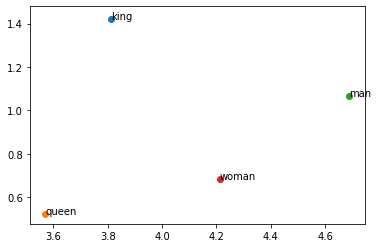

In [0]:
# Visualize
plot_embeddings(words=["king", "queen", "man", "woman"], 
                embeddings=glove, 
                pca_results=pca_results)

In [0]:
# Bias in embeddings
glove.most_similar(positive=['woman', 'doctor'], negative=['man'], topn=5)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('nurse', 0.7735227346420288),
 ('physician', 0.7189429998397827),
 ('doctors', 0.6824328303337097),
 ('patient', 0.6750682592391968),
 ('dentist', 0.6726033687591553)]

# Data

## Load data

We will download the [AG News dataset](http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html), which consists of 120000 text samples from 4 unique classes ('Business', 'Sci/Tech', 'Sports', 'World')

In [0]:
import pandas as pd
import re
import urllib

In [0]:
DATA_FILE = 'news.csv'
INPUT_FEATURE = 'title'
OUTPUT_FEATURE = 'category'

In [0]:
# Upload data from GitHub to notebook's local drive
url = "https://raw.githubusercontent.com/madewithml/lessons/master/data/news.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(DATA_FILE, 'wb') as fp:
    fp.write(html)

In [0]:
# Load data
df = pd.read_csv(DATA_FILE, header=0)
X = df[INPUT_FEATURE].values
y = df[OUTPUT_FEATURE].values
df.head(5)

,title,category
0,Wall St. Bears Claw Back Into the Black (Reuters),Business
1,Carlyle Looks Toward Commercial Aerospace (Reu...,Business
2,Oil and Economy Cloud Stocks' Outlook (Reuters),Business
3,Iraq Halts Oil Exports from Main Southern Pipe...,Business
4,"Oil prices soar to all-time record, posing new...",Business


## Split data

In [0]:
import collections
from sklearn.model_selection import train_test_split

In [0]:
TRAIN_SIZE = 0.7
VAL_SIZE = 0.15
TEST_SIZE = 0.15
SHUFFLE = True

In [0]:
def train_val_test_split(X, y, val_size, test_size, shuffle):
    """Split data into train/val/test datasets.
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, shuffle=shuffle)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=val_size, stratify=y_train, shuffle=shuffle)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [0]:
# Create data splits
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(
    X=X, y=y, val_size=VAL_SIZE, test_size=TEST_SIZE, shuffle=SHUFFLE)
class_counts = dict(collections.Counter(y))
print (f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print (f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print (f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print (f"Sample point: {X_train[0]} → {y_train[0]}")
print (f"Classes: {class_counts}")

X_train: (86700,), y_train: (86700,)
X_val: (15300,), y_val: (15300,)
X_test: (18000,), y_test: (18000,)
Sample point: Deep Impact Space Probe Aims to Slam Into Comet (Reuters) → Sci/Tech
Classes: {'Business': 30000, 'Sci/Tech': 30000, 'Sports': 30000, 'World': 30000}


## Tokenizer

Unlike the previous notebook, we will be processing our text at a word-level (as opposed to character-level).

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [0]:
FILTERS = "!\"'#$%&()*+,-./:;<=>?@[\\]^_`{|}~"
LOWER = True
CHAR_LEVEL = False

In [0]:
def decode(indices, tokenizer):
    """Decode a list of indices into string."""
    return " ".join([tokenizer.index_word[index] for index in indices])

In [0]:
# Input vectorizer
X_tokenizer = Tokenizer(
    filters=FILTERS, lower=LOWER, char_level=CHAR_LEVEL, oov_token='<UNK>')

In [0]:
# Fit only on train data
X_tokenizer.fit_on_texts(X_train)
vocab_size = len(X_tokenizer.word_index) + 1
print (f"# tokens: {vocab_size}")

# tokens: 29795


In [0]:
# Convert text to sequence of tokens
original_text = X_train[0]
X_train = np.array(X_tokenizer.texts_to_sequences(X_train))
X_val = np.array(X_tokenizer.texts_to_sequences(X_val))
X_test = np.array(X_tokenizer.texts_to_sequences(X_test))
preprocessed_text = decode(X_train[0], X_tokenizer)
print (f"{original_text} \n\t→ {preprocessed_text} \n\t→ {X_train[0]}")

Deep Impact Space Probe Aims to Slam Into Comet (Reuters) 
	→ deep impact space probe aims to slam into comet reuters 
	→ [2072, 1544, 92, 197, 563, 2, 2194, 69, 4804, 16]


## LabelEncoder

In [0]:
from sklearn.preprocessing import LabelEncoder

In [0]:
# Output vectorizer
y_tokenizer = LabelEncoder()

In [0]:
# Fit on train data
y_tokenizer = y_tokenizer.fit(y_train)
classes = list(y_tokenizer.classes_)
print (f"classes: {classes}")

classes: ['Business', 'Sci/Tech', 'Sports', 'World']


In [0]:
# Convert labels to tokens
y_train = y_tokenizer.transform(y_train)
y_val = y_tokenizer.transform(y_val)
y_test = y_tokenizer.transform(y_test)
print (f"y_train[0]: {y_train[0]}")

y_train[0]: 1


In [0]:
# Class weights
counts = np.bincount(y_train)
class_weights = {i: 1.0/count for i, count in enumerate(counts)}
print (f"class counts: {counts},\nclass weights: {class_weights}")

class counts: [21675 21675 21675 21675],
class weights: {0: 4.61361014994233e-05, 1: 4.61361014994233e-05, 2: 4.61361014994233e-05, 3: 4.61361014994233e-05}


## Datasets

In [0]:
import math
from tensorflow.keras.preprocessing.sequence import pad_sequences
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [0]:
BATCH_SIZE = 64
FILTER_SIZES = [2, 3, 4]

In [0]:
# Set seed for reproducibility
torch.manual_seed(SEED)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print (device)

cuda


In [0]:
class TextDataset(Dataset):
    """Text dataset."""
    def __init__(self, X, y, batch_size, max_filter_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.max_filter_size = max_filter_size
    
    def __str__(self):
        return f"<Dataset(N={len(self)}, batch_size={self.batch_size}, num_batches={self.get_num_batches()})>"

    def __len__(self):
        return len(self.y)

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return X, y

    def get_num_batches(self):
        return math.ceil(len(self)/self.batch_size)

    def collate_fn(self, batch):
        """Processing on a batch."""
        # Get inputs
        X = np.array(batch)[:, 0]
        y = np.array(batch)[:, 1]

        # Pad inputs
        max_seq_len = max(self.max_filter_size, max([len(x) for x in X]))
        X = pad_sequences(X, padding="post", maxlen=max_seq_len)

        # Cast
        X = torch.LongTensor(X.astype(np.int32))
        y = torch.LongTensor(y.astype(np.int32))

        return X, y

    def generate_batches(self, shuffle=False, drop_last=False):
        dataloader = DataLoader(dataset=self, batch_size=self.batch_size, 
                                collate_fn=self.collate_fn, 
                                shuffle=shuffle, drop_last=drop_last)
        for (X, y) in dataloader:
            yield X, y

In [0]:
# Create datasets
train_set = TextDataset(X=X_train, y=y_train, batch_size=BATCH_SIZE, max_filter_size=max(FILTER_SIZES))
val_set = TextDataset(X=X_val, y=y_val, batch_size=BATCH_SIZE, max_filter_size=max(FILTER_SIZES))
test_set = TextDataset(X=X_test, y=y_test, batch_size=BATCH_SIZE, max_filter_size=max(FILTER_SIZES))
print (train_set)
print (train_set[0])

<Dataset(N=86700, batch_size=64, num_batches=1355)>
([2072, 1544, 92, 197, 563, 2, 2194, 69, 4804, 16], 1)


In [0]:
# Generate batch
batch_X, batch_y = next(iter(test_set.generate_batches()))
print (batch_X.shape)
print (batch_y.shape)

torch.Size([64, 15])
torch.Size([64])


# Embedding

We can embed our inputs using the [embedding layer](https://pytorch.org/docs/stable/nn.html#torch.nn.Embedding).

In [0]:
import torch
import torch.nn as nn

In [0]:
# Input
x = torch.randint(high=10, size=(1,5)) # high = vocab size
print (x)
print (x.shape)

tensor([[5, 1, 6, 5, 6]])
torch.Size([1, 5])


In [0]:
# Embedding layer
embeddings = nn.Embedding(embedding_dim=100,
                          num_embeddings=10, # vocab size
                          padding_idx=0) # which id is for padding
print (embeddings.weight.shape)

torch.Size([10, 100])


In [0]:
# Embed the input
embeddings(x).shape

torch.Size([1, 5, 100])

Each id (token) in the input has been embedded using the embeddings. In the model below, we'll see how to preset our embeddings with our GloVe embeddings and how to choose whether to freeze (don't change during training) those embeddings or not. 

# Modeling

## Model

Let's visualize the model's forward pass.

1. We'll first tokenize our inputs (`batch_size`, `max_seq_len`).
2. Then we'll embed our tokenized inputs (`batch_size`, `max_seq_len`, `embedding_dim`).
3. We'll apply convolution via filters (`filter_size`, `vocab_size`, `num_filters`) followed by batch normalization. Our filters act as character level n-gram detecors. We have three different filter sizes (2, 3 and 4) and they will act as bi-gram, tri-gram and 4-gram feature extractors, respectivelyy. 
4. We'll apply 1D global max pooling which will extract the most relevant information from the feature maps for making the decision.
5. We feed the pool outputs to a fully-connected (FC) layer (with dropout).
6. We use one more FC layer with softmax to derive class probabilities. 

<div align="left">
<img src="https://raw.githubusercontent.com/madewithml/images/master/02_Basics/08_Embeddings/forward_pass.png" width="1000">
</div>

The `FILTER_SIZES` are [2, 3, 4] which effectively act as bi-gram, tri-gram and 4th-gram feature extractors when applied to our text.

In [0]:
import torch.nn.functional as F

In [0]:
class CNN(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters, 
                 filter_sizes, hidden_dim, dropout_p, num_classes, 
                 pretrained_embeddings=None, freeze_embeddings=False,
                 padding_idx=0):
        super(CNN, self).__init__()

        # Filter sizes
        self.filter_sizes = filter_sizes
        
        # Initialize embeddings
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                          num_embeddings=vocab_size,
                                          padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                           num_embeddings=vocab_size,
                                           padding_idx=padding_idx,
                                           _weight=pretrained_embeddings)
        
        # Freeze embeddings or not
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        
        # Conv weights
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim, 
                       out_channels=num_filters, 
                       kernel_size=f) for f in filter_sizes])
     
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, channel_first=False, apply_softmax=False):
        
        # Embed
        x_in = self.embeddings(x_in)

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        if not channel_first:
            x_in = x_in.transpose(1, 2)
            
        # Conv outputs
        z = []
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):
            # `SAME` padding
            padding_left = int((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))

            # Conv + pool
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))
            _z = F.max_pool1d(_z, _z.size(2)).squeeze(2)
            z.append(_z)
        
        # Concat conv outputs
        z = torch.cat(z, 1)

        # FC layers
        z = self.fc1(z)
        z = self.dropout(z)
        y_pred = self.fc2(z)
        
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return y_pred

## GloVe embeddings

In [0]:
def load_glove_embeddings(embeddings_file):
    """Load embeddings from a file."""
    embeddings = {}
    with open(embeddings_file, "r") as fp:
        for index, line in enumerate(fp):
            values = line.split()
            word = values[0]
            embedding = np.asarray(values[1:], dtype='float32')
            embeddings[word] = embedding
    return embeddings

In [0]:
def make_embeddings_matrix(embeddings, word_index, embedding_dim):
    """Create embeddings matrix to use in Embedding layer."""
    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [0]:
# Create embeddings
embeddings_file = 'glove.6B.{0}d.txt'.format(EMBEDDING_DIM)
glove_embeddings = load_glove_embeddings(embeddings_file=embeddings_file)
embedding_matrix = make_embeddings_matrix(embeddings=glove_embeddings, 
                                          word_index=X_tokenizer.word_index, 
                                          embedding_dim=EMBEDDING_DIM)
print (f"<Embeddings(words={embedding_matrix.shape[0]}, dim={embedding_matrix.shape[1]})>")

<Embeddings(words=29795, dim=100)>


## Training

In [0]:
class Trainer(object):

    def __init__(self, **kwargs):
        self.__dict__ = kwargs

    def train_loop(self, num_epochs):
        """Training and validation steps."""
        # Metrics
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        best_val_loss = np.inf

        # Epochs
        for epoch in range(num_epochs):
            # Steps
            self.train_step(epoch)
            self.val_step(epoch)
            print (f"Epoch: {epoch} | train_loss: {self.train_loss[-1]:.2f}, train_acc: {self.train_acc[-1]:.1f}, val_loss: {self.val_loss[-1]:.2f}, val_acc: {self.val_acc[-1]:.1f}")

            # Early stopping
            if self.val_loss[-1] < best_val_loss:
                best_val_loss = self.val_loss[-1]
                patience = self.patience # reset patience
            else:
                patience -= 1
            if not patience: # 0
                print ("Stopping early!")
                break

        return self.train_loss, self.train_acc, self.val_loss, self.val_acc, best_val_loss

    def train_step(self, epoch):
        """Training one epoch."""
        # Set model to train mode
        self.model.train()

        # Reset batch metrics
        running_train_loss = 0.0
        running_train_acc = 0.0

        # Iterate over train batches
        for i, (X, y) in enumerate(self.train_set.generate_batches()):

            # Set device
            X = X.to(self.device)
            y = y.to(self.device)

            # Forward pass
            y_pred = self.model(X)
            loss = self.loss_fn(y_pred, y)

            # Backward pass + optimize
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            # Metrics
            predictions = y_pred.max(dim=1)[1] # class
            accuracy = self.accuracy_fn(y_pred=predictions, y_true=y)

            # Update batch metrics
            running_train_loss += (loss - running_train_loss) / (i + 1)
            running_train_acc += (accuracy - running_train_acc) / (i + 1)
        
        # Update epoch metrics
        self.train_loss.append(running_train_loss)
        self.train_acc.append(running_train_acc)

        # Write to TensorBoard
        self.writer.add_scalar(tag='training loss', scalar_value=running_train_loss, global_step=epoch)
        self.writer.add_scalar(tag='training accuracy', scalar_value=running_train_acc, global_step=epoch)

    def val_step(self, epoch):
        """Validate one epoch."""
        # Set model to eval mode
        self.model.eval()

        # Reset batch metrics
        running_val_loss = 0.0
        running_val_acc = 0.0

        # Iterate over val batches
        for i, (X, y) in enumerate(self.val_set.generate_batches()):

            # Set device
            X = X.to(self.device)
            y = y.to(self.device)

            # Forward pass
            with torch.no_grad():
                y_pred = self.model(X)
                loss = self.loss_fn(y_pred, y)

            # Metrics
            predictions = y_pred.max(dim=1)[1] # class
            accuracy = self.accuracy_fn(y_pred=predictions, y_true=y)

            # Update batch metrics
            running_val_loss += (loss - running_val_loss) / (i + 1)
            running_val_acc += (accuracy - running_val_acc) / (i + 1)

        # Update epoch metrics
        self.val_loss.append(running_val_loss)
        self.val_acc.append(running_val_acc)

        # Write to TensorBoard
        self.writer.add_scalar(tag='validation loss', scalar_value=running_val_loss, global_step=epoch)
        self.writer.add_scalar(tag='validation accuracy', scalar_value=running_val_acc, global_step=epoch)

        # Adjust learning rate
        self.scheduler.step(running_val_loss)

    def test_loop(self):
        """Evalution of the test set."""
        # Metrics
        running_test_loss = 0.0
        running_test_acc = 0.0
        y_preds = []
        y_targets = []

        # Iterate over val batches
        for i, (X, y) in enumerate(self.test_set.generate_batches()):

            # Set device
            X = X.to(self.device)
            y = y.to(self.device)

            # Forward pass
            with torch.no_grad():
                y_pred = self.model(X)
                loss = self.loss_fn(y_pred, y)

            # Metrics
            predictions = y_pred.max(dim=1)[1] # class
            accuracy = self.accuracy_fn(y_pred=predictions, y_true=y)

            # Update batch metrics
            running_test_loss += (loss - running_test_loss) / (i + 1)
            running_test_acc += (accuracy - running_test_acc) / (i + 1)

            # Store values
            y_preds.extend(predictions.cpu().numpy())
            y_targets.extend(y.cpu().numpy())

        return running_test_loss, running_test_acc, y_preds, y_targets

## Experiments

Once you have chosen your embeddings, you can choose to freeze them or continue to train them using the supervised data (this could lead to overfitting). In this example, we will do three experiments: 
* frozen GloVe embeddings
* fine-tuned (unfrozen) GloVe embeddings
* randomly initialized embeddings

In [0]:
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [0]:
EMBEDDING_DIM = 100
NUM_FILTERS = 50
HIDDEN_DIM = 100
DROPOUT_P = 0.1
LEARNING_RATE = 1e-3
PATIENCE = 3
NUM_EPOCHS = 10

### GloVe embeddings (frozen)

In [0]:
FREEZE_EMBEDDINGS = True

In [0]:
# Initialize model
glove_frozen_model = CNN(embedding_dim=EMBEDDING_DIM,
                         vocab_size=vocab_size,
                         num_filters=NUM_FILTERS,
                         filter_sizes=FILTER_SIZES,
                         hidden_dim=HIDDEN_DIM,
                         dropout_p=DROPOUT_P,
                         num_classes=len(classes),
                         pretrained_embeddings=embedding_matrix,
                         freeze_embeddings=FREEZE_EMBEDDINGS).to(device)
model = glove_frozen_model
print (model.named_parameters)
# summary(model, input_size=(10, vocab_size)) # bug: can't make inputs into LongTensor

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(29795, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [0]:
# Loss
weights = torch.Tensor([class_weights[key] for key in sorted(class_weights.keys())]).to(device)
loss_fn = nn.CrossEntropyLoss(weight=weights)

In [0]:
# Accuracy
def accuracy_fn(y_pred, y_true):
    n_correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (n_correct / len(y_pred)) * 100
    return accuracy

In [0]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [0]:
# Create writer to store values 
log_dir = 'tensorboard/glove_frozen'
!rm -rf log_dir # remove if it already exists
writer = SummaryWriter(log_dir=log_dir)

In [0]:
# Train
trainer = Trainer(train_set=train_set, val_set=val_set, test_set=test_set, 
                  model=model, optimizer=optimizer, scheduler=scheduler, 
                  loss_fn=loss_fn, accuracy_fn=accuracy_fn, patience=PATIENCE, 
                  writer=writer, device=device)
train_loss, train_acc, val_loss, val_acc, best_val_loss = trainer.train_loop(num_epochs=NUM_EPOCHS)

Epoch: 0 | train_loss: 0.44, train_acc: 84.5, val_loss: 0.41, val_acc: 85.7
Epoch: 1 | train_loss: 0.36, train_acc: 87.5, val_loss: 0.40, val_acc: 86.0
Epoch: 2 | train_loss: 0.31, train_acc: 89.1, val_loss: 0.41, val_acc: 85.9
Epoch: 3 | train_loss: 0.28, train_acc: 90.2, val_loss: 0.42, val_acc: 85.6
Epoch: 4 | train_loss: 0.25, train_acc: 91.3, val_loss: 0.46, val_acc: 84.9
Stopping early!


### Fine-tuned GloVe embeddings (unfrozen)

In [0]:
# Arguments
FREEZE_EMBEDDINGS = False

In [0]:
# Initialize model
glove_finetuned_model = CNN(embedding_dim=EMBEDDING_DIM,
                         vocab_size=vocab_size,
                         num_filters=NUM_FILTERS,
                         filter_sizes=FILTER_SIZES,
                         hidden_dim=HIDDEN_DIM,
                         dropout_p=DROPOUT_P,
                         num_classes=len(classes),
                         pretrained_embeddings=embedding_matrix,
                         freeze_embeddings=FREEZE_EMBEDDINGS).to(device)
model = glove_finetuned_model
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(29795, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [0]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [0]:
# Create writer to store values 
log_dir = 'tensorboard/glove_finetuned'
!rm -rf log_dir # remove if it already exists
writer = SummaryWriter(log_dir=log_dir)

In [0]:
# Train
trainer = Trainer(train_set=train_set, val_set=val_set, test_set=test_set, 
                  model=model, optimizer=optimizer, scheduler=scheduler, 
                  loss_fn=loss_fn, accuracy_fn=accuracy_fn, patience=PATIENCE, 
                  writer=writer, device=device)
train_loss, train_acc, val_loss, val_acc, best_val_loss = trainer.train_loop(num_epochs=NUM_EPOCHS)

Epoch: 0 | train_loss: 0.41, train_acc: 85.8, val_loss: 0.36, val_acc: 87.8
Epoch: 1 | train_loss: 0.27, train_acc: 90.7, val_loss: 0.36, val_acc: 87.9
Epoch: 2 | train_loss: 0.19, train_acc: 93.7, val_loss: 0.42, val_acc: 87.1
Epoch: 3 | train_loss: 0.12, train_acc: 95.9, val_loss: 0.54, val_acc: 86.0
Stopping early!


### Randomly initialized embeddings

In [0]:
# Arguments
FREEZE_EMBEDDINGS = False

In [0]:
randomly_initialized_model = CNN(embedding_dim=EMBEDDING_DIM,
                               vocab_size=vocab_size,
                               num_filters=NUM_FILTERS,
                               filter_sizes=FILTER_SIZES,
                               hidden_dim=HIDDEN_DIM,
                               dropout_p=DROPOUT_P,
                               num_classes=len(classes),
                               pretrained_embeddings=None,
                               freeze_embeddings=FREEZE_EMBEDDINGS).to(device)
model = randomly_initialized_model
print (model.named_parameters)

<bound method Module.named_parameters of CNN(
  (embeddings): Embedding(29795, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


In [0]:
# Optimizer
optimizer = Adam(model.parameters(), lr=LEARNING_RATE) 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

In [0]:
# Create writer to store values 
log_dir = 'tensorboard/randomly_initialized'
!rm -rf log_dir # remove if it already exists
writer = SummaryWriter(log_dir=log_dir)

In [0]:
# Train
trainer = Trainer(train_set=train_set, val_set=val_set, test_set=test_set, 
                  model=model, optimizer=optimizer, scheduler=scheduler, 
                  loss_fn=loss_fn, accuracy_fn=accuracy_fn, patience=PATIENCE, 
                  writer=writer, device=device)
train_loss, train_acc, val_loss, val_acc, best_val_loss = trainer.train_loop(num_epochs=NUM_EPOCHS)

Epoch: 0 | train_loss: 0.81, train_acc: 68.0, val_loss: 0.68, val_acc: 75.1
Epoch: 1 | train_loss: 0.46, train_acc: 83.7, val_loss: 0.60, val_acc: 79.7
Epoch: 2 | train_loss: 0.32, train_acc: 89.3, val_loss: 0.62, val_acc: 80.6
Epoch: 3 | train_loss: 0.22, train_acc: 92.6, val_loss: 0.65, val_acc: 81.0
Epoch: 4 | train_loss: 0.16, train_acc: 94.6, val_loss: 0.78, val_acc: 80.7
Stopping early!


## Evaluation

Looks like fine-tuned glove embeddings had the best test performance (based on validation accuracy) so let's do proper evaluation and inference with that strategy.

In [0]:
import io
import itertools
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    """Plot a confusion matrix using ground truth and predictions."""
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    #  Figure
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Axis
    plt.title("Confusion matrix")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    ax.set_xticklabels([''] + classes)
    ax.set_yticklabels([''] + classes)
    ax.xaxis.set_label_position('bottom') 
    ax.xaxis.tick_bottom()

    # Values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:d} ({cm_norm[i, j]*100:.1f}%)",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Display
    plt.show()

In [0]:
def get_performance(y_true, y_pred, classes):
    """Per-class performance metrics. """
    performance = {'overall': {}, 'class': {}}
    metrics = precision_recall_fscore_support(y_true, y_pred)

    # Overall performance
    performance['overall']['precision'] = np.mean(metrics[0])
    performance['overall']['recall'] = np.mean(metrics[1])
    performance['overall']['f1'] = np.mean(metrics[2])
    performance['overall']['num_samples'] = np.float64(np.sum(metrics[3]))

    # Per-class performance
    for i in range(len(classes)):
        performance['class'][classes[i]] = {
            "precision": metrics[0][i],
            "recall": metrics[1][i],
            "f1": metrics[2][i],
            "num_samples": np.float64(metrics[3][i])
        }

    return performance

In [0]:
# Test loop
model = glove_finetuned_model
test_loss, test_acc, y_preds, y_targets = trainer.test_loop()
print (f"test_loss: {test_loss:.2f}, test_acc: {test_acc:.1f}")

test_loss: 0.81, test_acc: 80.5


In [0]:
# Class performance
performance = get_performance(y_true=y_targets, y_pred=y_preds, classes=classes)
print (json.dumps(performance, indent=4))

{
    "overall": {
        "precision": 0.8082926724993051,
        "recall": 0.8055555555555556,
        "f1": 0.804132788567085,
        "num_samples": 18000.0
    },
    "class": {
        "Business": {
            "precision": 0.7660519884470117,
            "recall": 0.7662222222222222,
            "f1": 0.7661370958782358,
            "num_samples": 4500.0
        },
        "Sci/Tech": {
            "precision": 0.8533227429176595,
            "recall": 0.7162222222222222,
            "f1": 0.778784583786396,
            "num_samples": 4500.0
        },
        "Sports": {
            "precision": 0.7872219053051911,
            "recall": 0.92,
            "f1": 0.8484475868429142,
            "num_samples": 4500.0
        },
        "World": {
            "precision": 0.8265740533273582,
            "recall": 0.8197777777777778,
            "f1": 0.8231618877607945,
            "num_samples": 4500.0
        }
    }
}


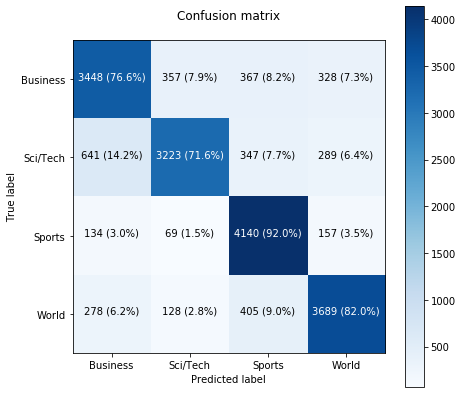

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      4500
           1       0.85      0.72      0.78      4500
           2       0.79      0.92      0.85      4500
           3       0.83      0.82      0.82      4500

    accuracy                           0.81     18000
   macro avg       0.81      0.81      0.80     18000
weighted avg       0.81      0.81      0.80     18000



In [0]:
# Confusion matrix
plt.rcParams["figure.figsize"] = (7,7)
plot_confusion_matrix(y_targets, y_preds, classes=classes)
print (classification_report(y_targets, y_preds))

## Inference

In [0]:
import collections

In [0]:
def get_probability_distributions(probabilities, classes):
    """Produce probability distributions with labels."""
    probability_distributions = []
    for i, y_prob in enumerate(probabilities):
        probability_distribution = {}
        for j, prob in enumerate(y_prob):
            probability_distribution[classes[j]] = np.float64(prob)
        probability_distribution = collections.OrderedDict(
            sorted(probability_distribution.items(), key=lambda kv: kv[1], reverse=True))
        probability_distributions.append(probability_distribution)
    return probability_distributions

In [0]:
# Inputs
texts = ["This weekend the greatest tennis players will fight for the championship."]
num_samples = len(texts)
X_infer = np.array(X_tokenizer.texts_to_sequences(texts))
print (f"{texts[0]} \n\t→ {decode(X_infer[0], X_tokenizer)} \n\t→ {X_infer[0]}")
print (f"len(X_infer[0]): {len(X_infer[0])} words")
y_filler = np.array([0]*num_samples)

This weekend the greatest tennis players will fight for the championship. 
	→ this weekend the greatest tennis players will fight for the championship 
	→ [ 268 2165   10 6842  869  376   61  241    5   10 1516]
len(X_infer[0]): 11 words


In [0]:
# Dataset
infer_set = TextDataset(X=X_infer, y=y_filler, batch_size=BATCH_SIZE, max_filter_size=max(FILTER_SIZES))

In [0]:
# Iterate over val batches
probabilities = []
for i, batch in enumerate(infer_set.generate_batches()):
    
    # Cast
    X, y = batch
    X = X.to(device)
    y = y.to(device)

    # Forward pass
    with torch.no_grad():
        y_pred = model(X, apply_softmax=True)

    # Save probabilities
    probabilities.extend(y_pred.cpu().numpy())

In [0]:
# Results
probability_distributions = get_probability_distributions(probabilities=probabilities,
                                                          classes=classes)
results = []
for index in range(num_samples):
    results.append({
        'raw_input': texts[index],
        'preprocessed_input': decode(indices=X_infer[index], tokenizer=X_tokenizer),
        'probabilities': probability_distributions[index]
                   })
print (json.dumps(results, indent=4))

[
    {
        "raw_input": "This weekend the greatest tennis players will fight for the championship.",
        "preprocessed_input": "this weekend the greatest tennis players will fight for the championship",
        "probabilities": {
            "Sports": 1.0,
            "World": 2.1505472749816512e-11,
            "Business": 2.7825421952459503e-15,
            "Sci/Tech": 1.327035507034998e-15
        }
    }
]


# Interpretability

Recall that each our unique filter sizes (2, 3 and 4) act as n-gram feature detectors. When these filters convolve on our embedded input (`N`, `max_seq_len`, `embedding_dim`), they produce feature maps which are shape ((`N`, `max_seq_len`, `num_filters`) for each filter size. Since we used `SAME` padding with stride=1, our feature maps have the same length as our inputs ('max_seq_len') which you can think of as what the filters extracted from each n-gram window. When we apply 1d global max-pooling we're effectively extracting the most relevant information from the feature maps. We can inspect the trained model at the pooling step to determine which n-grams were most relevant towards the prediction.

In [0]:
import seaborn as sns
from statistics import mode

We're going to copy the same model structure as before but now we'll stop just after convolution since those are the outputs we care about.

In [0]:
class ConvOutputsModels(nn.Module):
    def __init__(self, embedding_dim, vocab_size, num_filters, 
                 filter_sizes, hidden_dim, dropout_p, num_classes,
                 pretrained_embeddings=None, freeze_embeddings=False, 
                 padding_idx=0):
        super(ConvOutputsModels, self).__init__()

        # Filter sizes
        self.filter_sizes = filter_sizes
        
        # Initialize embeddings
        if pretrained_embeddings is None:
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                          num_embeddings=vocab_size,
                                          padding_idx=padding_idx)
        else:
            pretrained_embeddings = torch.from_numpy(pretrained_embeddings).float()
            self.embeddings = nn.Embedding(embedding_dim=embedding_dim,
                                           num_embeddings=vocab_size,
                                           padding_idx=padding_idx,
                                           _weight=pretrained_embeddings)
        
        # Freeze embeddings or not
        if freeze_embeddings:
            self.embeddings.weight.requires_grad = False
        
        # Conv weights
        self.conv = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim, 
                       out_channels=num_filters, 
                       kernel_size=f) for f in filter_sizes])
        
        # FC weights
        self.dropout = nn.Dropout(dropout_p)
        self.fc1 = nn.Linear(num_filters*len(filter_sizes), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x_in, channel_first=False, apply_softmax=False):
        
        # Embed
        x_in = self.embeddings(x_in)

        # Rearrange input so num_channels is in dim 1 (N, C, L)
        if not channel_first:
            x_in = x_in.transpose(1, 2)
            
        # Conv outputs
        z = []
        max_seq_len = x_in.shape[2]
        for i, f in enumerate(self.filter_sizes):
            # `SAME` padding
            padding_left = int((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2)
            padding_right = int(math.ceil((self.conv[i].stride[0]*(max_seq_len-1) - max_seq_len + self.filter_sizes[i])/2))
            
            # Conv
            _z = self.conv[i](F.pad(x_in, (padding_left, padding_right)))
            z.append(_z)
        
        return z

In [0]:
# Initialize model
model = ConvOutputsModels(embedding_dim=EMBEDDING_DIM,
                          vocab_size=vocab_size,
                          num_filters=NUM_FILTERS,
                          filter_sizes=FILTER_SIZES, 
                          hidden_dim=HIDDEN_DIM, 
                          dropout_p=DROPOUT_P, 
                          num_classes=len(classes),
                          pretrained_embeddings=embedding_matrix,
                          freeze_embeddings=FREEZE_EMBEDDINGS).to(device)
print (model.named_parameters)

<bound method Module.named_parameters of ConvOutputsModels(
  (embeddings): Embedding(29795, 100, padding_idx=0)
  (conv): ModuleList(
    (0): Conv1d(100, 50, kernel_size=(2,), stride=(1,))
    (1): Conv1d(100, 50, kernel_size=(3,), stride=(1,))
    (2): Conv1d(100, 50, kernel_size=(4,), stride=(1,))
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (fc1): Linear(in_features=150, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=4, bias=True)
)>


Since we already trained our model, we'll transfer those weights to our new model.

In [0]:
# Transfer weights
model.load_state_dict(glove_finetuned_model.state_dict())

<All keys matched successfully>

In [0]:
# Iterate over val batches
conv_outputs = []
for i, batch in enumerate(infer_set.generate_batches()):
    
    # Cast
    X, y = batch
    X = X.to(device)
    y = y.to(device)

    # Forward pass
    with torch.no_grad():
        z = model(X, apply_softmax=True)
    
    # Save
    conv_outputs.extend(z)

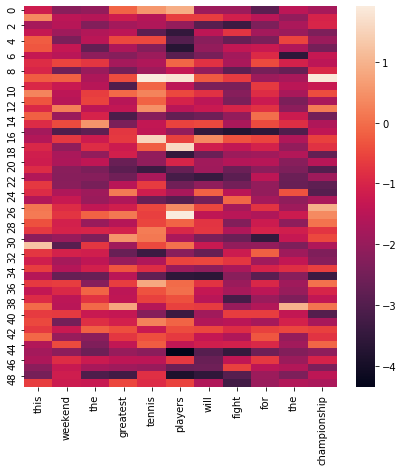

In [0]:
# Visualize bi-gram filters
tokens = decode(X_infer[0], X_tokenizer).split()
sns.heatmap(conv_outputs[1][0].cpu(), xticklabels=tokens)

1D global max-pooling would extract the highest value from each of our num_filters for each filter size. We could also follow this same approach to figure out which n-gram is most relevant but notice in the heatmap above that many filters don't have much variance. To mitigate this, this [paper](https://www.aclweb.org/anthology/W18-5408/) uses threshold values to determine which filters to use for interpretability. 

To keep things simple and since the feature map values are fairly normalized, we'll just take the sum of values for each token index and use the index that has the max value as th emost influential index.

In [0]:
sample_index = 0
print (f"Preprocessed text:\n{decode(indices=X_infer[sample_index], tokenizer=X_tokenizer)}")
print ("\nMost important n-grams:")
# Process conv outputs for each unique filter size
for i, filter_size in enumerate(FILTER_SIZES):
    
    # Identify most important n-gram
    filter_sums = np.sum(conv_outputs[i][sample_index].T.cpu().numpy(), axis=1)
    
    # Get corresponding text
    start = np.argmax(filter_sums)
    gram = " ".join([X_tokenizer.index_word[index] for index in X_infer[sample_index][start:start+filter_size]])
    print (f"[{filter_size}-gram]: {gram}")

Preprocessed text:
this weekend the greatest tennis players will fight for the championship

Most important n-grams:
[2-gram]: championship
[3-gram]: this weekend the
[4-gram]: championship


---
Share and discover ML projects at <a href="https://madewithml.com/">Made With ML</a>.

<div align="left">
<a class="ai-header-badge" target="_blank" href="https://github.com/madewithml/lessons"><img src="https://img.shields.io/github/stars/madewithml/lessons.svg?style=social&label=Star"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://www.linkedin.com/company/madewithml"><img src="https://img.shields.io/badge/style--5eba00.svg?label=LinkedIn&logo=linkedin&style=social"></a>&nbsp;
<a class="ai-header-badge" target="_blank" href="https://twitter.com/madewithml"><img src="https://img.shields.io/twitter/follow/madewithml.svg?label=Follow&style=social"></a>
</div>
             